## Mini Projet Apprentissage Artificel : Groupe Paul Garnier - Arthur Verrez

(à rendre pour le vendredi 16/11/18)

Choix du sujet : Transfer Learning 

Nous allons utiliser le ConvNet construit par Google et notamment François Chollet : [Papier d'origine](https://arxiv.org/abs/1610.02357)

Le réseau se base sur des modules, que l'on présente ci-dessous : 

![inception-module](inception-module.png "Module Inception V3")

Chacun de ces modules vont "s'empiler" pour former notre réseau total. On présente sa forme complète ci-dessous : 

![xception](xception.png "Xception ConvNet")

C'est un réseau qui obtient de très bonnes performances, tout en limitant son nombre de paramètres (22 millions de paramètres). 

![xception-resultats](xception-resultats.png "Xception ConvNet")

## Mise en place du modèle : 

Nous allons commencer par mettre en place nos ConvNet, ainsi que les modules dont nous auront besoin : 

In [1]:
## Imports des différents modules, hors Keras: 
## ===============================

import os
import copy
import sys
import numpy as np
# et pour l'affichage : 

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

# Pour Keras : 


from keras import backend as K
from keras import __version__

# Pour charger notre modèle : 
from keras.applications.xception import Xception, preprocess_input
from keras.models import Model
from keras.models import load_model

# Pour modifier notre modèle : 

from keras.layers import Dense, MaxPooling2D, AveragePooling2D, GlobalAveragePooling2D, Input, Flatten, Dropout
from keras.optimizers import SGD

# Pour modifier nos images et les utiliser : 

from keras.preprocessing.image import ImageDataGenerator
print("done.")

/Users/paulgarnier/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


done.


Nous allons maintenant configurer les paramètres que nous allons utiliser :  

In [3]:
WIDTH, HEIGHT = 299, 299 #fixed size for InceptionV3
CHANNEL = 3
NB_EPOCHS = 10
BAT_SIZE = 16
FC_SIZE = 1024
NB_IMG_TRAIN = 200
NB_IMG_VAL = 40
BAT_SIZE_TEST = 4
nb_classes = 7
print("done.")

done.


On peut maintenant charger notre modèle : 

In [4]:
model_xception = Xception(input_tensor = Input(shape=(WIDTH,HEIGHT,CHANNEL)),
                          weights='imagenet', # On le prend, pre-trained sur imagesnet. 
                          include_top=False) # Pour enlever la couche Dense(1000) de classification
print("done.")

done.


On va maintenant construire nos fonctions pour le transfer learning. 

Globalement, cela représente : 

- une fonction pour modifier notre réseau (changer les dernières couches)
- une fonction pour freeze l'entrainement de toutes les couches, sauf la dernière
- une fonction pour freeze l'entrainement d'une nombre choisit de couches (fine tunning)


In [5]:
"""
On rajoute des nouvelles couches à notre modèle, et on le retourne

"""

def nouvelle_couche(model, nb_classes):
    x = model.output
    x = AveragePooling2D((10,10), padding='valid')(x) # On place un avg_pooling de taille 10x10 pour limiter les paramètres
    x = Dropout(0.7)(x) # On place du dropout, pour éviter l'overfitting.
    x = Flatten()(x) 
    x = Dense(2048,activation='relu')(x)
    x = Dropout(0.7)(x)
    predictions = Dense(nb_classes, activation='softmax')(x)
    new_model = Model(inputs=model.input, outputs=predictions)
    return new_model

print("done.")

done.


In [6]:
"""
On freeze l'intégralité des couches de notre premier modèle : ici le xception.
On compile ensuite notre modèle total et on affiche sa structure.
On renvoie aussi le nombre de couches.
"""

def freeze_full(new_model, model): 
    print("Nombre de couche dans le modèle de base := {}".format(len(model.layers)))
    for layer in model.layers:
        layer.trainable = False
    new_model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    new_model.summary()
    
print("done.")

done.


In [7]:
"""
Ici, on ne freeze les couches que jusqu'à un certains index : 
"""

def freeze_some(new_model,model,indx):
    cpt = 0
    for layer in model.layers:
        layer.trainable = False
        cpt+=1
        if cpt > indx:
            break 
    new_model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    new_model.summary()
    
print("done.")

done.


Il reste maintenant à mettre en place tout notre modèle.
Pour l'instant, on évite des choix de paramètres tricky, et on freeze tout le Xception de départ : 

In [8]:
# On rajoute nos couches à la fin 

model = nouvelle_couche(model_xception, nb_classes)

# On met en place le freeze, jusqu'à la couche 127. 

freeze_full(model,model_xception)
#freeze_some(model,model_xception,127)

Nombre de couche dans le modèle de base := 132
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
______________________________________________________________

## Mise en place du dataset  : 

Nous nous intéressons au fait de pouvoir différencier des plats culinaires, nous nous sommes notamment concentré sur la reconnaissance des plats suivants:

- des Hamburgers :

![title](img/h1.jpg)
![title](img/h2.jpg)

- des pates : 

![title](img/p1.jpg)
![title](img/p2.jpg)

- des sushis ainsi que des makis :

![title](img/su1.jpg)
![title](img/su2.jpg)

- des baozhi :

![title](img/b1.jpg)
![title](img/b2.jpg)

- des soupes de ramen :

![title](img/r1.jpg)
![title](img/r2.jpg)

- et de la salade :

![title](img/s1.jpg)
![title](img/s2.jpg)


Pour chacune de ces 6 catégories, nous avons sélectionné 50 images d'entrainement et 10 images de validation. Cependant, il est important de noter que chacun de ces dataset présentent des images très différentes (par exemple des pâtes à la carbonara ou des pâtes au pesto), avec différents points de vus et éclairages.


On va utiliser les fonctionnalités de Keras, on énonce d'abord nos différents paramètres : 

In [9]:
## Pour l'entrainement : 
#On limite ces paramètre, comme on travail sur des visages.

# ======================


rotationTrain = 30 
width_shiftTrain = 0.2
height_shiftTrain = 0.2
shearTrain = 0.1
zoomTrain = 0.05
flipTrain = False

## Pour les test : 

# ==============

rotationTest = 0. 
width_shiftTest = 0.1
height_shiftTest = 0.1
shearTest = 0.1
zoomTest = 0.05
flipTest = False

print("done.")

done.


On peut maintenant créer nos différents [ImageDataGenerator](https://keras.io/preprocessing/image/)
Les data pour les tests et la validation seront les même. 

Cela va aussi permettre de faire face à la petite taille de nos données : chaque image est ainsi modifiée légérement de façon aléatoire.

In [10]:


trainDataGenerator = ImageDataGenerator(
        rotation_range= rotationTrain,
        width_shift_range= width_shiftTrain,
        height_shift_range= height_shiftTrain,
        shear_range= shearTrain,
        zoom_range= zoomTrain,
        rescale=1./255,
        horizontal_flip= flipTrain,
        vertical_flip =  flipTrain,
        fill_mode='nearest')

testDataGenerator = ImageDataGenerator(
        rotation_range= rotationTest,
        width_shift_range= width_shiftTest,
        height_shift_range= height_shiftTest,
        shear_range= shearTest,
        zoom_range= zoomTest,
        rescale=1./255,
        horizontal_flip= flipTest,
        vertical_flip = flipTest,
        fill_mode='nearest')

print("done.")

done.


Les data sont en .zip sur GitHub. 
Elles sont placées en 2 dossiers : un training, et un validation. 
Chacun de ces deux dossiers comprend ensuite 7 dossiers : sushi, ramen, rice, hamburger, salade, pasta et baozhi.

Ces différents dossiers comprennent les images que nous allons utiliser. 

## On met ici en place les directions pour ces dossiers (à changer modifier)

In [11]:


trainImg = '/Users/paulgarnier/Desktop/Files/Cours/Mines/2A/ApprentissageArtificiel/training/' 
validationImg = '/Users/paulgarnier/Desktop/Files/Cours/Mines/2A/ApprentissageArtificiel/validation/'

print("done.")

done.


Finalement, on lance nos dataGenerator avec ces images :  

In [12]:

trainGenerator = trainDataGenerator.flow_from_directory(
                    trainImg,
                    target_size=(WIDTH,HEIGHT),
                    batch_size=BAT_SIZE,
                    color_mode='rgb',
                    class_mode='categorical')
testGenerator = testDataGenerator.flow_from_directory(
                    validationImg,
                    target_size=(WIDTH,HEIGHT),
                    batch_size=BAT_SIZE_TEST,
                    color_mode='rgb',
                    class_mode='categorical') 
print("done.")

Found 350 images belonging to 7 classes.
Found 70 images belonging to 7 classes.
done.


## Entraînement du modèle : 

On peut maintenant entrainer le modèle, puis analyser nos résultats. 
On définit tout d'abord le nom de notre modèle pour pouvoir le sauvegarder sur notre ordinateur.

In [13]:
saveName = "xception_face.model"
print("done.")

done.


In [35]:
## et on lance le training : 
## ========================

history = model.fit_generator(trainGenerator,
                              steps_per_epoch=NB_IMG_TRAIN/BAT_SIZE,
                              epochs=50,
                              validation_data=testGenerator,
                              validation_steps=NB_IMG_VAL/BAT_SIZE_TEST,
                                 verbose=1) 


model.save(saveName)
print("done.")

Epoch 1/50
13/12 [===============================] - 84s 6s/step - loss: 2.1532 - acc: 0.2356 - val_loss: 1.4414 - val_acc: 0.4500
Epoch 2/50
13/12 [===============================] - 77s 6s/step - loss: 1.6695 - acc: 0.4272 - val_loss: 0.9879 - val_acc: 0.6842
Epoch 3/50
13/12 [===============================] - 85s 7s/step - loss: 1.2385 - acc: 0.5913 - val_loss: 0.9464 - val_acc: 0.6500
Epoch 4/50
13/12 [===============================] - 77s 6s/step - loss: 1.2130 - acc: 0.5975 - val_loss: 1.0897 - val_acc: 0.6316
Epoch 5/50
13/12 [===============================] - 81s 6s/step - loss: 1.1885 - acc: 0.6202 - val_loss: 0.5974 - val_acc: 0.8500
Epoch 6/50
13/12 [===============================] - 79s 6s/step - loss: 1.0982 - acc: 0.6251 - val_loss: 1.0042 - val_acc: 0.7368
Epoch 7/50
13/12 [===============================] - 86s 7s/step - loss: 0.9484 - acc: 0.6588 - val_loss: 0.5722 - val_acc: 0.8500
Epoch 8/50
13/12 [===============================] - 84s 6s/step - loss: 0.9779 - a

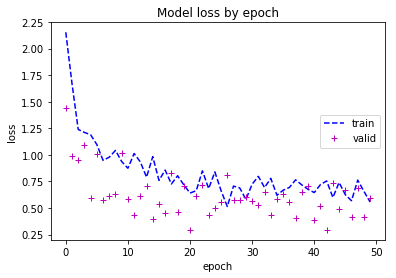

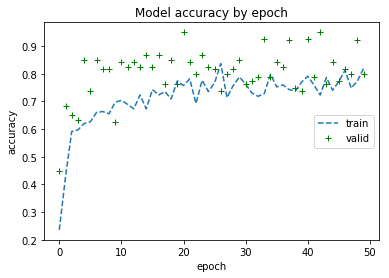

In [36]:
plt.plot(history.history['loss'],'b--')
plt.plot(history.history['val_loss'],'m+')
plt.title('Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='right')
plt.show()

plt.plot(history.history['acc'],'--')
plt.plot(history.history['val_acc'],'g+')
plt.title('Model accuracy by epoch')
plt.ylabel('accuracy')
plt.legend(['train', 'valid'], loc='right')
plt.xlabel('epoch')
plt.show()


On reload notre modèle pour pouvoir le réutiliser par la suite : 

In [37]:
traine_model = load_model('xception_face.model')
print("done.")

done.


## Test et analyse du modèle : 

In [38]:
## Chemin vers les images pour l'analyse : 
## =======================================
analyse_path = '/Users/paulgarnier/Desktop/Files/Cours/Mines/2A/ApprentissageArtificiel/test/' 

print("done.")

done.


In [39]:
## Pour display nos images test : 

from keras.preprocessing import image
print("done.")

done.


In [40]:
## Création du tableau : 
## ====================

data = []

## Ajout des images et des prédictions : 
## =================

for name in os.listdir(analyse_path):
    img_path = analyse_path+name
    if name != ".DS_Store":
        img = image.load_img(path=img_path,grayscale=False,target_size=(299,299,3))
        img_array = image.img_to_array(img)
        img_array /= 255.
        # Prédictions : 
    
        pred = traine_model.predict(np.array([img_array]))
    
        data_image = [img_array,pred,name]
        data.append(data_image)
    
print("done.")

done.


On va maintenant les afficher : 

In [45]:
## On définit ici la fonction qui va permettre d'afficher les images, ainsi qu'un histogramme de probabilité : 

food = ('baozhi', 'hamburger', 'pasta', 'ramen', 'rice','salad','sushi')
y_pos = np.arange(len(food))

def display(img,proba,name):
    fig, axes = plt.subplots(2,1)
    
    axIMG = axes[0]
    axPROBA = axes[1]
    
    plt.title(name,loc='right')
    axIMG.imshow(img,aspect=1)
    #proba = np.array(proba)
    axPROBA.barh(y_pos,proba, align='center',color='green')
    axPROBA.set_yticks(y_pos)
    axPROBA.set_yticklabels(food)
    axPROBA.invert_yaxis()  
    axPROBA.set_xlabel('Probabilité')
    plt.show()

print("done.")

done.


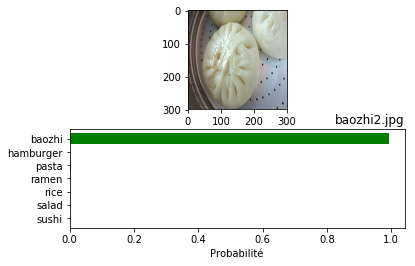

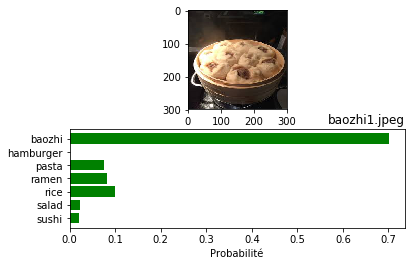

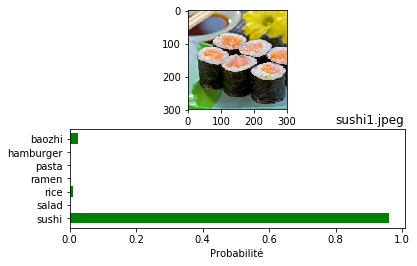

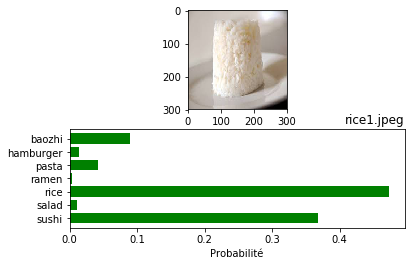

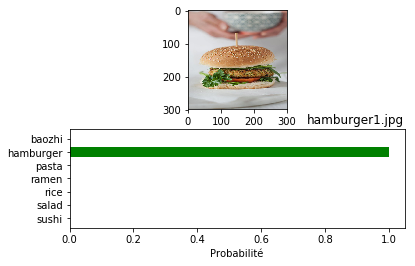

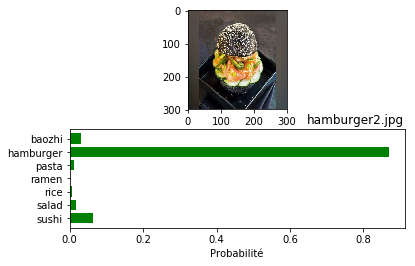

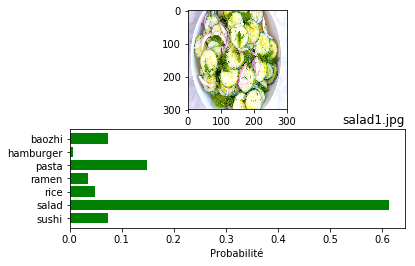

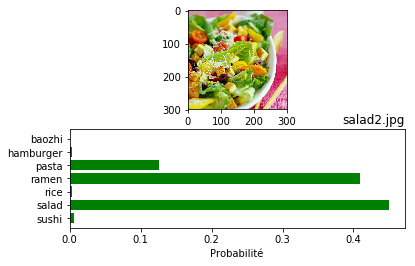

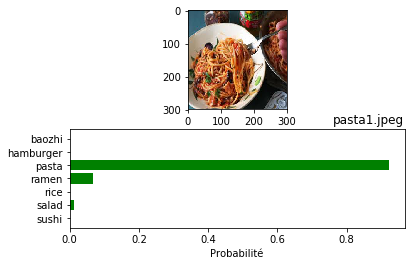

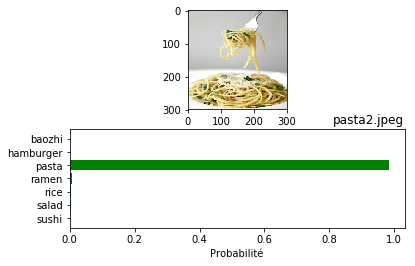

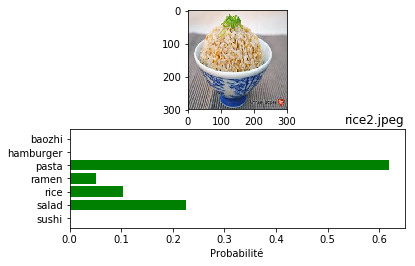

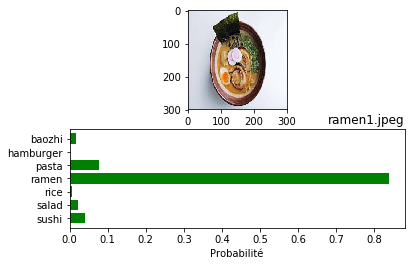

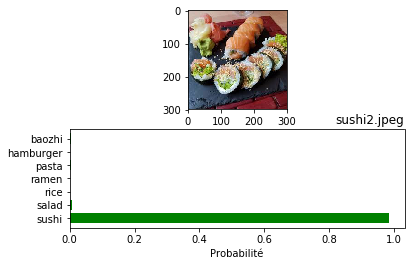

done.


In [46]:
## Display des images : 

for img,proba,title in data:
    
    display(img,proba[0],title)
    
print("done.")

## Analyse des résultats et retour sur le modèle

Le modèle final présente une accuracy dans un intervalle de 80-95%. Il semblerait que l'algorithme confond parfois des pâtes et du riz, et des sushis et du riz. Cela est probablement dû au fait que notre dataset n'est pas de taille suffisante étant donné la variabilité des images de certains plats. Dans les exemples ci-dessus, la seule mauvaise prédiction est sur une photo de riz qui présente des caractéristiques totalement différentes de notre training set: coloré alors que la plupart de notre training set est composé de riz blanc.

Pour réaliser un modèle plus fiable, nous aurions pu considérer différentes possibilités:
- il serait intéressant d'utiliser une plus grand base de données, cependant, vu le temps imparti pour ce projet, nous n'avons pas pu considérer ce choix du fait du temps d'entraînement qui aurait été plus long.
- Nous aurions également pu réaliser des classes plus précises (par exemple, pâtes au pesto, pâtes à la carbonara).
- les couches que nous avons rajoutées commencent par un average-pooling de taille 10x10, nous pourrions diminuer la taille du pooling pour augmenter notre précision, cependant, passer d'un filtre 10x10 à un filtre 2x2 rajouterait approximativement 4 millions de trainable paramètres, ce qui, encore une fois, augmenterait le temps de training.
- De plus, pour maximiser la rapidité de l'entraînement, nous avons décidé de freeze l'intégralité du modèle xception de départ, nous aurions pu préférer une méthode de fine-tuning plus longue, mais plus précise et avec de meilleurs résultats en freezant d'abord les 120/132 premières couches, puis les 127/132 premières couches et finalement la totalité des 132 couches du modèle xception.
- Nous pourrions augmenter les paramètres liés aux ImageGenerator, notamment le height et width shift, le zoom range et le rotation range, ainsi que les flips left right et top down, en effet, après réflexion, nos images s'y prêtaient bien.

Cependant, malgré le dataset de faible taille et le nombre important d'epoch, notre algorithme ne semble pas présenter d'overfitting, cela est notamment dû aux 2 couches de dropout entre les couches denses de sortie de réseau avec des paramètres de 0.6.

Compte tenu des deux graphiques d'accuracy, et vu la taille du training set, un plus grand nombre d'epoch semblait inutile.

Compte tenu du choix d'un optimizer égal à Adam, il n'y a pas besoin de réfléchir au learning rate, Adam proposant déjà un learning rate adaptatif.


## New training : 

Pour tenter de comparer notre modèle, nous allons réaliser un deuxième entraînement.

Nous allons : 

- changer les paramètres de dataGenerator,
- changer le freeze du modèle,
- diminuer la taille de notre averagePooling de départ


In [14]:
## Nouveaux paramètres : 
## =====================

## Pour l'entrainement : 
#On limite ces paramètre, comme on travail sur des visages.

# ======================


rotationTrain = 45 
width_shiftTrain = 0.2
height_shiftTrain = 0.2
shearTrain = 0.1
zoomTrain = 0.2
flipTrain = True

## Pour les test : 

# ==============

rotationTest = 0.10 
width_shiftTest = 0.1
height_shiftTest = 0.1
shearTest = 0.1
zoomTest = 0.05
flipTest = False

print("done.")

## =====================
## =====================



trainDataGenerator = ImageDataGenerator(
        rotation_range= rotationTrain,
        width_shift_range= width_shiftTrain,
        height_shift_range= height_shiftTrain,
        shear_range= shearTrain,
        zoom_range= zoomTrain,
        rescale=1./255,
        horizontal_flip= flipTrain,
        vertical_flip =  flipTrain,
        fill_mode='nearest')

testDataGenerator = ImageDataGenerator(
        rotation_range= rotationTest,
        width_shift_range= width_shiftTest,
        height_shift_range= height_shiftTest,
        shear_range= shearTest,
        zoom_range= zoomTest,
        rescale=1./255,
        horizontal_flip= flipTest,
        vertical_flip = flipTest,
        fill_mode='nearest')

print("done.")

## =====================
## =====================

trainImg = '/Users/paulgarnier/Desktop/Files/Cours/Mines/2A/ApprentissageArtificiel/training/' 
validationImg = '/Users/paulgarnier/Desktop/Files/Cours/Mines/2A/ApprentissageArtificiel/validation/'

print("done.")

## =====================
## =====================


trainGenerator = trainDataGenerator.flow_from_directory(
                    trainImg,
                    target_size=(WIDTH,HEIGHT),
                    batch_size=BAT_SIZE,
                    color_mode='rgb',
                    class_mode='categorical')
testGenerator = testDataGenerator.flow_from_directory(
                    validationImg,
                    target_size=(WIDTH,HEIGHT),
                    batch_size=BAT_SIZE_TEST,
                    color_mode='rgb',
                    class_mode='categorical') 
print("done.")

## =====================
## =====================

saveName = "xception_new.model"
print("done.")

done.
done.
done.
Found 350 images belonging to 7 classes.
Found 70 images belonging to 7 classes.
done.
done.


In [15]:
## Changement du freeze : 
## =======================

model_xception = Xception(input_tensor = Input(shape=(WIDTH,HEIGHT,CHANNEL)),
                          weights='imagenet', # On le prend, pre-trained sur imagesnet. 
                          include_top=False) # Pour enlever la couche Dense(1000) de classification
print("done.")

## =====================
## =====================

"""
Nouvelle taille de pooling : 
"""
def nouvelle_couche(model, nb_classes):
    x = model.output
    x = AveragePooling2D((6,6), padding='valid')(x) # On place un avg_pooling de taille 10x10 pour limiter les paramètres
    x = Dropout(0.7)(x) # On place du dropout, pour éviter l'overfitting.
    x = Flatten()(x) 
    x = Dense(2048,activation='relu')(x)
    x = Dropout(0.7)(x)
    predictions = Dense(nb_classes, activation='softmax')(x)
    new_model = Model(inputs=model.input, outputs=predictions)
    return new_model

print("done.")

## =====================
## =====================

# On rajoute nos couches à la fin 

model = nouvelle_couche(model_xception, nb_classes)

# On met en place le freeze, jusqu'à la couche 127. 

#freeze_full(model,model_xception)
freeze_some(model,model_xception,127)

## =====================
## =====================

done.
done.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 149, 149, 32) 864         input_2[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 149, 149, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 149, 149, 32) 0           block1_conv1_bn[0][0]            
_________________________________________________________________________________________________

In [16]:
## et on lance le training : 
## ========================

history = model.fit_generator(trainGenerator,
                              steps_per_epoch=NB_IMG_TRAIN/BAT_SIZE,
                              epochs=50,
                              validation_data=testGenerator,
                              validation_steps=NB_IMG_VAL/BAT_SIZE_TEST,
                                 verbose=1) 


model.save(saveName)
print("done.")

Epoch 1/50
13/12 [===============================] - 90s 7s/step - loss: 2.5177 - acc: 0.1731 - val_loss: 1.3450 - val_acc: 0.4500
Epoch 2/50
13/12 [===============================] - 82s 6s/step - loss: 1.7004 - acc: 0.4628 - val_loss: 0.6987 - val_acc: 0.8158
Epoch 3/50
13/12 [===============================] - 81s 6s/step - loss: 1.2080 - acc: 0.6058 - val_loss: 1.1242 - val_acc: 0.7500
Epoch 4/50
13/12 [===============================] - 81s 6s/step - loss: 0.9888 - acc: 0.7136 - val_loss: 0.8763 - val_acc: 0.7105
Epoch 5/50
13/12 [===============================] - 83s 6s/step - loss: 1.0790 - acc: 0.6683 - val_loss: 0.7546 - val_acc: 0.7750
Epoch 6/50
13/12 [===============================] - 80s 6s/step - loss: 0.7806 - acc: 0.7261 - val_loss: 1.2282 - val_acc: 0.6842
Epoch 7/50
13/12 [===============================] - 81s 6s/step - loss: 0.7064 - acc: 0.7659 - val_loss: 0.5051 - val_acc: 0.9000
Epoch 8/50
13/12 [===============================] - 82s 6s/step - loss: 0.7559 - a

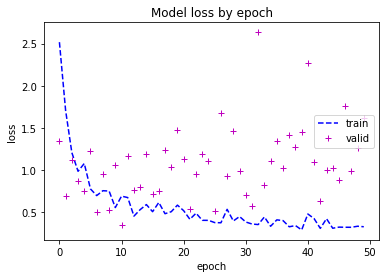

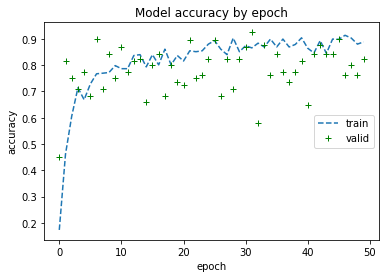

In [17]:
plt.plot(history.history['loss'],'b--')
plt.plot(history.history['val_loss'],'m+')
plt.title('Model loss by epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='right')
plt.show()

plt.plot(history.history['acc'],'--')
plt.plot(history.history['val_acc'],'g+')
plt.title('Model accuracy by epoch')
plt.ylabel('accuracy')
plt.legend(['train', 'valid'], loc='right')
plt.xlabel('epoch')
plt.show()

On va comparer les résultats avec notre premier entraînement : 

In [18]:
## Data du premier entraînement : 


old_history = [[2.1532, 0.2356, 1.4414, 0.45], [1.6695, 0.4272, 0.9879, 0.6842], [1.2385, 0.5913, 0.9464, 0.65], [1.213, 0.5975, 1.0897, 0.6316], [1.1885, 0.6202, 0.5974, 0.85], [1.0982, 0.6251, 1.0042, 0.7368], [0.9484, 0.6588, 0.5722, 0.85], [0.9779, 0.6635, 0.6142, 0.8158], [1.0395, 0.6565, 0.628, 0.8158], [0.9365, 0.6971, 1.0196, 0.625], [0.8736, 0.7046, 0.5859, 0.8421], [1.007, 0.6908, 0.4316, 0.825], [0.9334, 0.6731, 0.6161, 0.8421], [0.7948, 0.7213, 0.7074, 0.825], [0.9826, 0.6731, 0.4001, 0.8684], [0.7595, 0.7425, 0.5377, 0.825], [0.856, 0.7226, 0.4547, 0.8684], [0.7255, 0.7356, 0.8286, 0.7632], [0.8013, 0.7088, 0.4662, 0.85], [0.7172, 0.774, 0.7051, 0.7632], [0.6417, 0.7582, 0.2933, 0.95], [0.6662, 0.781, 0.6131, 0.8421], [0.8488, 0.6923, 0.7121, 0.8], [0.6803, 0.7774, 0.4314, 0.8684], [0.8391, 0.7356, 0.5031, 0.825], [0.6649, 0.7665, 0.5566, 0.8158], [0.5136, 0.8365, 0.8134, 0.7368], [0.7074, 0.7123, 0.5703, 0.8], [0.6906, 0.7569, 0.5742, 0.8158], [0.5797, 0.7885, 0.6055, 0.85], [0.7204, 0.763, 0.5654, 0.7632], [0.7973, 0.7308, 0.5232, 0.775], [0.6899, 0.7184, 0.6521, 0.7895], [0.7839, 0.7274, 0.437, 0.925], [0.6192, 0.7981, 0.585, 0.7895], [0.6702, 0.7514, 0.6292, 0.8421], [0.6928, 0.7596, 0.5557, 0.825], [0.7691, 0.7418, 0.4021, 0.9211], [0.717, 0.7377, 0.6483, 0.75], [0.6749, 0.7692, 0.7026, 0.7368], [0.6412, 0.7925, 0.3881, 0.925], [0.72, 0.7596, 0.5217, 0.7895], [0.7549, 0.7226, 0.296, 0.95], [0.6012, 0.7851, 0.7317, 0.7632], [0.7396, 0.7404, 0.492, 0.8421], [0.622, 0.7726, 0.6697, 0.775], [0.5679, 0.8125, 0.4107, 0.8158], [0.7602, 0.7473, 0.6886, 0.8], [0.656, 0.774, 0.4102, 0.9211], [0.5542, 0.8207, 0.5899, 0.8]]
legende = ['loss','acc','val_loss','val_acc']

## création de nos 4 tableaux : 

oldLoss = []
oldAcc = []
oldValLoss = []
oldValAcc = []

for values in old_history:
    oldLoss.append(values[0])
    oldAcc.append(values[1])
    oldValLoss.append(values[2])
    oldValAcc.append(values[3])

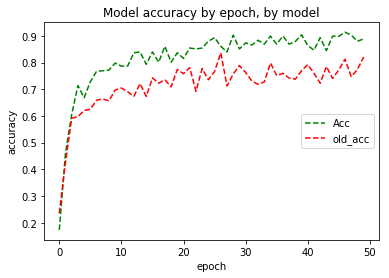

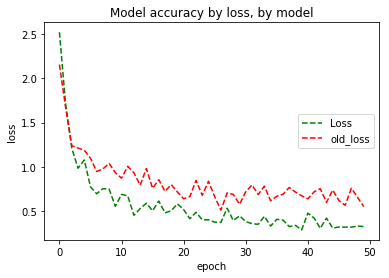

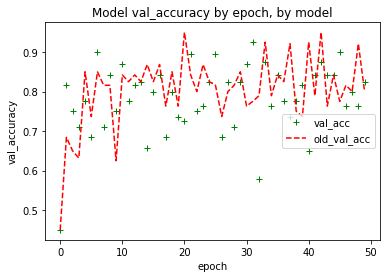

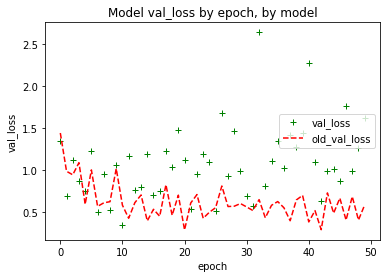

In [21]:
## Plot des comparaisons : 

plt.plot(history.history['acc'],'g--')
plt.plot(oldAcc,'r--')
plt.title('Model accuracy by epoch, by model')
plt.ylabel('accuracy')
plt.legend(['Acc', 'old_acc'], loc='right')
plt.xlabel('epoch')
plt.show()

plt.plot(history.history['loss'],'g--')
plt.plot(oldLoss,'r--')
plt.title('Model accuracy by loss, by model')
plt.ylabel('loss')
plt.legend(['Loss', 'old_loss'], loc='right')
plt.xlabel('epoch')
plt.show()

plt.plot(history.history['val_acc'],'g+')
plt.plot(oldValAcc,'r--')
plt.title('Model val_accuracy by epoch, by model')
plt.ylabel('val_accuracy')
plt.legend(['val_acc', 'old_val_acc'], loc='right')
plt.xlabel('epoch')
plt.show()

plt.plot(history.history['val_loss'],'g+')
plt.plot(oldValLoss,'r--')
plt.title('Model val_loss by epoch, by model')
plt.ylabel('val_loss')
plt.legend(['val_loss', 'old_val_loss'], loc='right')
plt.xlabel('epoch')
plt.show()

Sur le training, on peut remarquer des meilleurs résultats avec notre nouveau modèle. C'est tout à fait logique. En effet, on présente une augmentation de "trainable parameters" de 7,374,343 <= 4,210,695, soit 75%. 

En revanche, cette augmentation de paramètre, ainsi que que la conservation du même nombre d'épochs (50) à causé de l'overfitting. Les résultats sur le validation set sont moins bon avec le nouveaux modèle, et surtout, dès les graphes de comptes rendus de l'apprentissage, on se rend compte que : 

- la val-acc est plus faible en moyenne que la training_acc
- la val_acc semble légérement décroitre avec le nombre d'épochs

Notre modèle est donc maintenant trop complexe. 

Réalisons tout de même un affichage des prédictions, pour comparer avec le premier modèle : 

In [23]:
## Chemin vers les images pour l'analyse : 
## =======================================
analyse_path = '/Users/paulgarnier/Desktop/Files/Cours/Mines/2A/ApprentissageArtificiel/test/' 

print("done.")

## =========== 

## Pour display nos images test : 

from keras.preprocessing import image
print("done.")

## ========== 

## Création du tableau : 
## ====================

data = []

## Ajout des images et des prédictions : 
## =================

for name in os.listdir(analyse_path):
    img_path = analyse_path+name
    if name != ".DS_Store":
        img = image.load_img(path=img_path,grayscale=False,target_size=(299,299,3))
        img_array = image.img_to_array(img)
        img_array /= 255.
        # Prédictions : 
    
        pred = model.predict(np.array([img_array]))
    
        data_image = [img_array,pred,name]
        data.append(data_image)
    
print("done.")

done.
done.
done.


done.


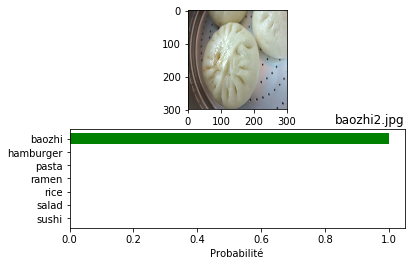

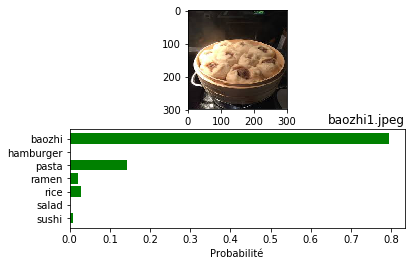

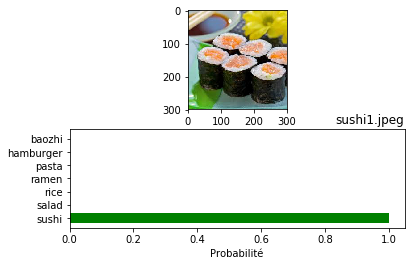

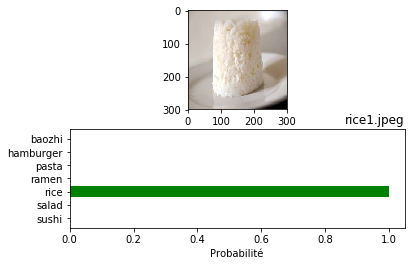

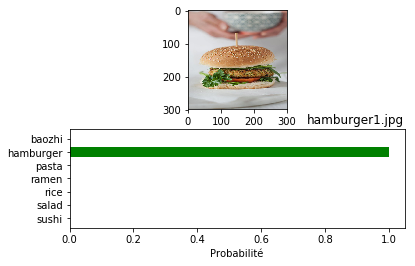

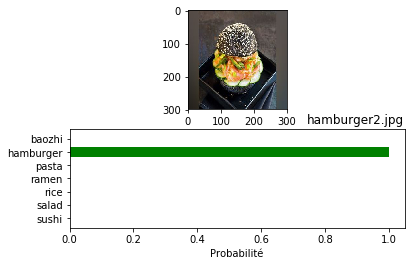

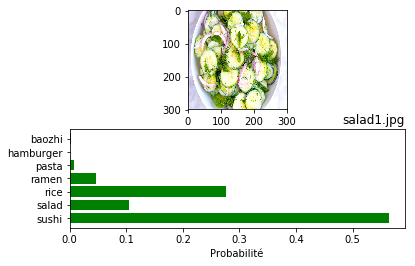

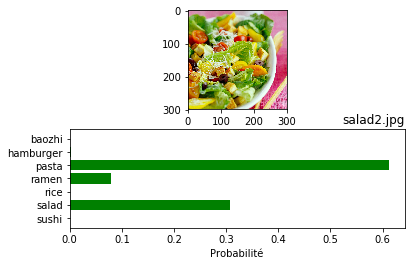

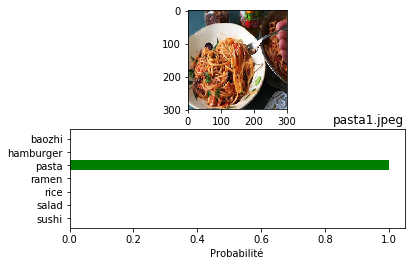

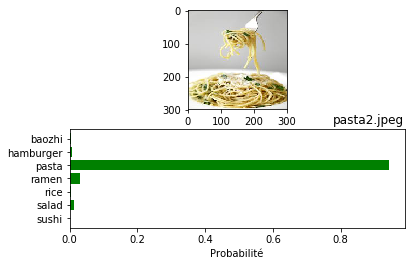

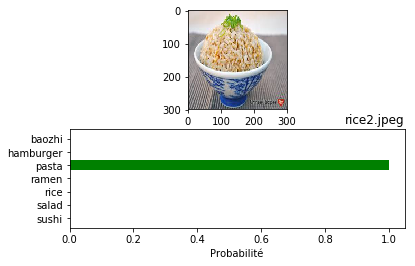

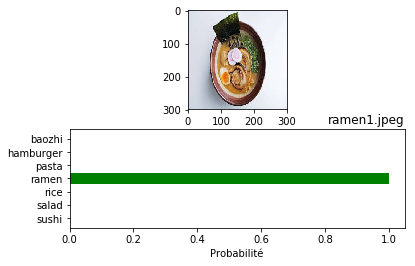

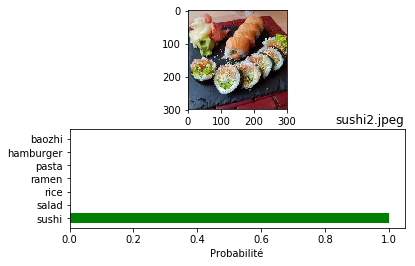

done.


In [24]:
## On définit ici la fonction qui va permettre d'afficher les images, ainsi qu'un histogramme de probabilité : 

food = ('baozhi', 'hamburger', 'pasta', 'ramen', 'rice','salad','sushi')
y_pos = np.arange(len(food))

def display(img,proba,name):
    fig, axes = plt.subplots(2,1)
    
    axIMG = axes[0]
    axPROBA = axes[1]
    
    plt.title(name,loc='right')
    axIMG.imshow(img,aspect=1)
    #proba = np.array(proba)
    axPROBA.barh(y_pos,proba, align='center',color='green')
    axPROBA.set_yticks(y_pos)
    axPROBA.set_yticklabels(food)
    axPROBA.invert_yaxis()  
    axPROBA.set_xlabel('Probabilité')
    plt.show()

print("done.")

## Display des images : 

for img,proba,title in data:
    
    display(img,proba[0],title)
    
print("done.")

Par rapport au premier modèle, deux nouvelles erreurs font leurs apparitions : salad1 et salad2. 